In [9]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#c8abc9','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V3

animal = 'BS_100'

ops_directory = 'D:\\OpsinTest_Cache'
beh_directory = 'Z:\\Behavioor'


stdfont = 14
stdyfrac = 0.06

In [2]:
EnumM2Session = []
EnumM2Clust = []

sessions = os.listdir(ops_directory)

numM2 = 0

for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    if sessionfile.meta.task not in ['opto nonreversal','opto switch','opto reversal']:
        continue


    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumM2Session.append(session)
            EnumM2Clust.append(clust)    
    else:
        pass

print('M2       : ' + str(numM2))

100%|██████████| 2/2 [00:00<00:00, 99.90it/s]

M2       : 14


In [144]:
M2_sessions = np.unique(EnumM2Session)

In [145]:
M2_sessions

array(['BS_100_101_opto_M2.pickle', 'BS_100_102_opto_M2.pickle'],
      dtype='<U25')

In [35]:
 sessionfile.responsiveness[clust]['laser_on'].FRmodulation

1.8415637860082292

In [36]:
 sessionfile.responsiveness[clust]['laser_off'].FRmodulation

1.5535714285714288

In [34]:
FRmod = []
FRmod_On = []
FRmod_Off = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumM2Session,EnumM2Clust))):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    
    try:
        print(clust)
        FRmod_clust = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        FRmod_On_clust = sessionfile.responsiveness[clust]['laser_on'].FRmodulation
        FRmod_Off_clust = sessionfile.responsiveness[clust]['laser_off'].FRmodulation
        
        FRmod.append(FRmod_clust)
        FRmod_On.append(FRmod_On_clust)
        FRmod_Off.append(FRmod_Off_clust)
        
    except Exception as e:
        FRmod = np.nan
        
    
    
    

14it [00:00, 160.98it/s]

6
36
39
59
60
78
115
118
90
104
107
124
160
167


In [37]:
FRmod_On = np.array(FRmod_On)
FRmod_Off = np.array(FRmod_Off)

In [38]:
FRmod_On

array([ 2.40918803, 12.40384615,  2.35042735,  2.7457265 , 22.78846154,
        3.50282486,  6.34615385, 13.37606838,  6.40957447,  3.71175523,
        5.40084388,  5.50925926,  0.72435897,  1.84156379])

In [39]:
FRmod_Off

array([10.08680556, 25.88541667,  0.6712963 , 14.34027778, 26.22106481,
        2.8978979 ,  9.13194444, 21.24421296,  8.13218391,  4.22279793,
        6.54761905,  3.02631579,  1.59214092,  1.55357143])

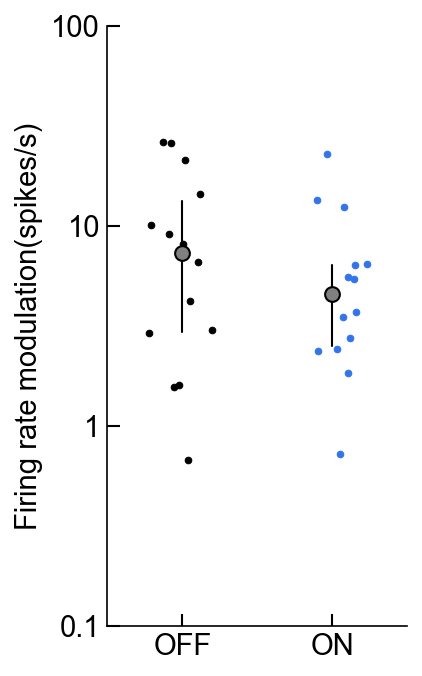

In [112]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
size=10

################################################################################################################

data_on =FRmod_On
data_off = FRmod_Off

labels = ['OFF','ON']
numCon = 2

wid = 0.75
widsc = wid/1.75#*1.125

X = np.ones_like(data_off)*0
_,Y = ilep.violin(X,data_off,width=wid,minjitter=0.075)
X,_ = ilep.violin(X,np.log10(data_off),width=wid,minjitter=0.075)
#X -= widsc
ax.scatter(X, Y, s=size, c='black', lw=0.5,zorder=-10,label='Laser OFF')

X = np.ones_like(data_on)*1
_,Y = ilep.violin(X,data_on,width=wid,minjitter=0.075)
X,_ = ilep.violin(X,np.log10(data_on),width=wid,minjitter=0.075)
#X += widsc
ax.scatter(X, Y, s=size, c=LASER_COLOR, lw=0.5,zorder=-10,label='Laser ON')


######################################

FRmod_baseline_median = 3.5
column = data_off
column = ilep.rmnan(column)
percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
eye_color= NCR_CR_cmap((percentCR-40)/20)
border_color = 'k'#eye_color

summary_size=50
summary_width=1

Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
ax.scatter([0], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
ax.plot([0,0], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


column = data_on
column = ilep.rmnan(column)
percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
eye_color= NCR_CR_cmap((percentCR-40)/20)
border_color = 'k'#eye_color

summary_size=50
summary_width=1

Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
ax.scatter([1], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
ax.plot([1,1], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

################################################################################################################

labels = ['OFF','ON']

ax.set_ylim([0,100])
ylab = ax.set_ylabel('Firing rate modulation (spikes/s)')

ax.set_yscale('log',subs=[])
ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ylab = ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,1.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)

artists = [ylab]

In [70]:
sessionfile.responsiveness[clust]['laser_on'].trials

array([  1,   3,   4,   5,   8,  12,  15,  16,  18,  19,  21,  23,  24,
        26,  27,  29,  31,  35,  36,  38,  41,  42,  43,  44,  46,  52,
        53,  54,  55,  56,  58,  59,  63,  64,  65,  66,  67,  68,  72,
        73,  74,  77,  83,  85,  88,  90,  91,  92,  94,  97,  98,  99,
       102, 105, 107, 108, 110, 112, 113, 114, 116, 118, 119, 121, 123,
       125, 126, 127, 128, 129, 131, 132, 136, 139, 142, 145, 146, 147,
       148, 149, 150, 151, 155, 156, 158, 160, 163, 164, 165, 167, 170,
       174, 175, 176, 177, 179, 180, 181, 184, 188, 189, 191, 192, 195,
       198, 199, 202, 203, 205, 206, 208, 209, 210, 211, 212, 218, 221,
       223, 225, 228, 229, 232, 234, 235, 236, 237, 238, 241, 242, 243,
       244, 245, 246, 252, 253, 255, 257, 258, 259, 260, 261, 262, 263,
       268, 269, 270, 273, 274, 275, 278, 279, 283, 284, 290, 291, 292,
       293, 294, 298, 299, 300, 301])

In [172]:
def visualizeCluster(sessionfile,clust):
    starttime = -50
    endtime = 150
    bw_scott_factor = 3

    buffer = 50
    bufferedstart = starttime - buffer
    bufferedend = endtime + buffer
    startbuffer = (0-bufferedstart)/1000
    endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

    #########################################################################################

    region = sessionfile.meta.region

    #########################################################################################

    fig = plt.figure(figsize=(4,6))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH

    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)

    trialsToPlot_on = sessionfile.responsiveness[clust]['laser_on'].trials
    trialsToPlot_off = sessionfile.responsiveness[clust]['laser_off'].trials
    
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    
    trialSpikes_on = []
    trialSpikes_off = []
    
    for trial in trialsToPlot_on:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes_on.append(this_trial_spikes)
    trialSpikes_on = np.array(trialSpikes_on,dtype='object')

    for trial in trialsToPlot_off:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes_off.append(this_trial_spikes)
    trialSpikes_off = np.array(trialSpikes_off,dtype='object')
    
    #Plot Raster
    # for idx,trial in enumerate(trialsToPlot_on):
    #     ax1.scatter(trialSpikes_on[idx],np.ones_like(trialSpikes_on[idx])*idx,color=LASER_COLOR,s=1.5,marker='o',lw=0)
    # for idx,trial in enumerate(trialsToPlot_off):
    #     ax1.scatter(trialSpikes_off[idx],np.ones_like(trialSpikes_off[idx])*idx,color='black',s=1.5,marker='o',lw=0)
    for idx,trial in enumerate(trialsToPlot_on):
        ax1.scatter(trialSpikes_on[idx],np.ones_like(trialSpikes_on[idx])*idx,color=LASER_COLOR,s=1.5,marker='o',lw=0)
    #for idx,trial in enumerate(trialsToPlot_off):
        #ax1.scatter(trialSpikes_off[idx],np.ones_like(trialSpikes_off[idx])*idx,color='black',s=1.5,marker='o',lw=0)



    #Plot PSTH
    #On
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_on)):
        PSTHspikes = np.concatenate(trialSpikes_on[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_on = np.mean(FR,axis=0)
    sem_FR_on = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR_on,lw=2,color=LASER_COLOR)
    
    max_FR_value_on = np.max(avg_FR_on+sem_FR_on) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_on)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')
    
    #laser line
    ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)

    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([-50,0,50,100,150])
    ax2.set_xticklabels(['-50','0','50','100','150'])
    ax2.set_xlabel('Time (s)')

    #Off
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_off)):
        PSTHspikes = np.concatenate(trialSpikes_off[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_off = np.mean(FR,axis=0)
    sem_FR_off = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR_off,lw=2,color='black')

    
    return fig,[ax1,ax2]




(<Figure size 600x900 with 2 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:xlabel='Time (s)', ylabel='Firing rate (spikes/s)'>])

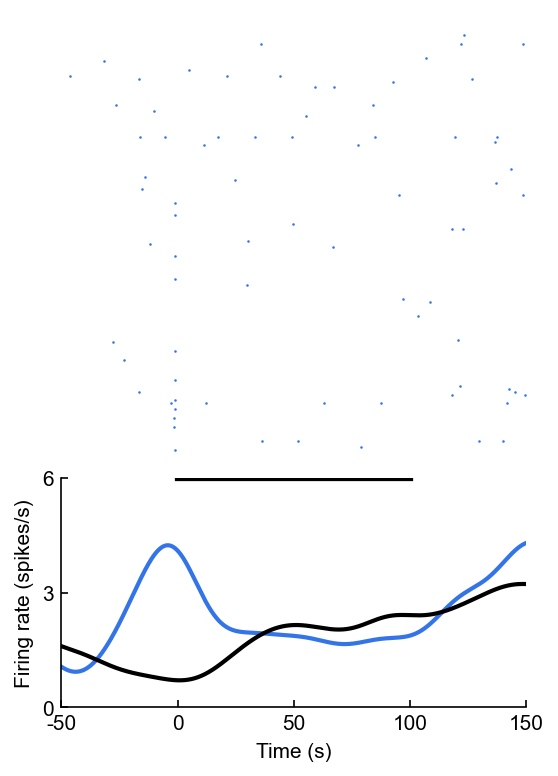

In [173]:
visualizeCluster(sessionfile,clust)

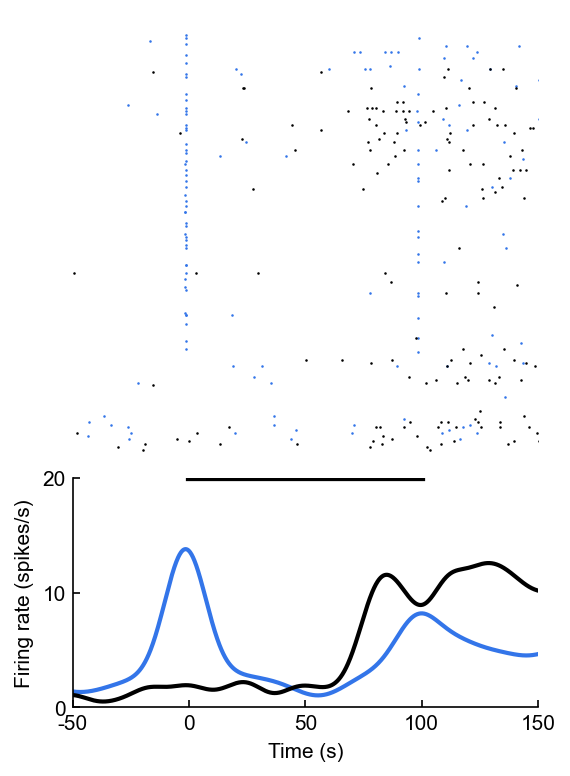

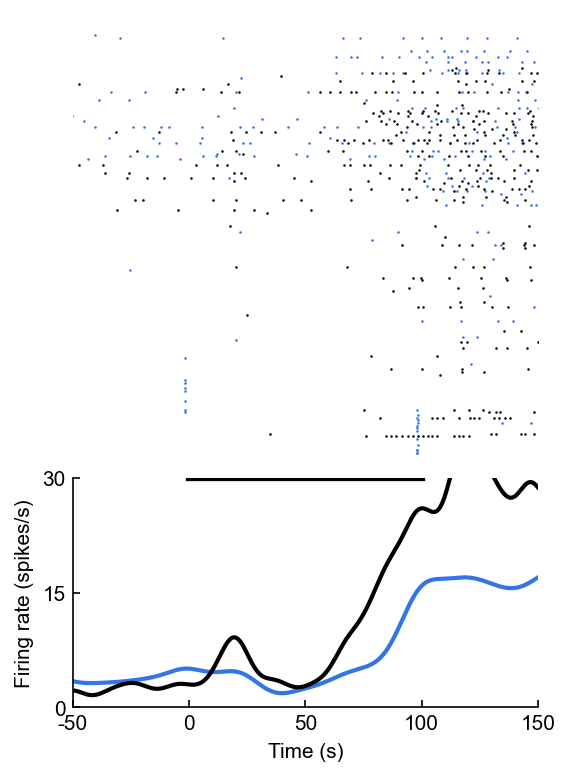

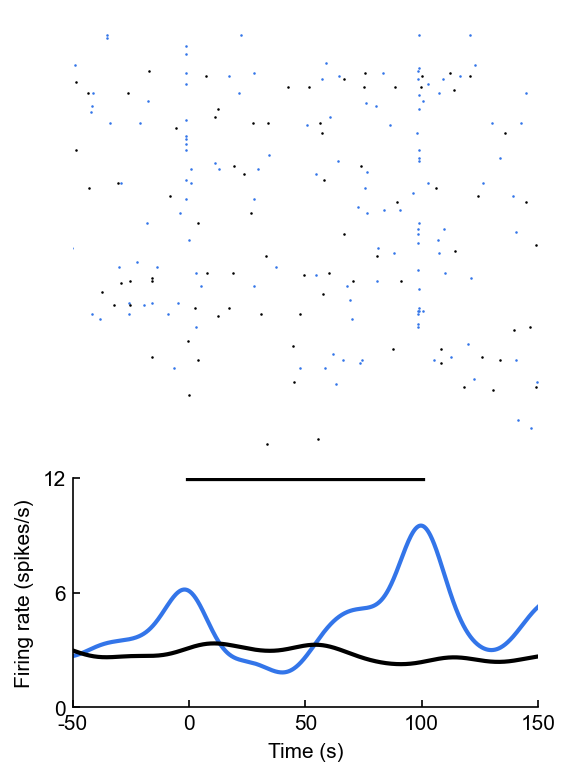

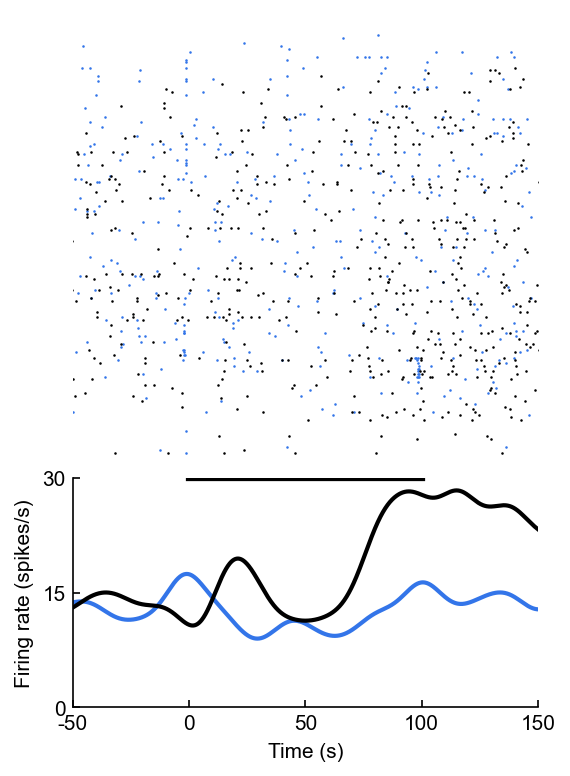

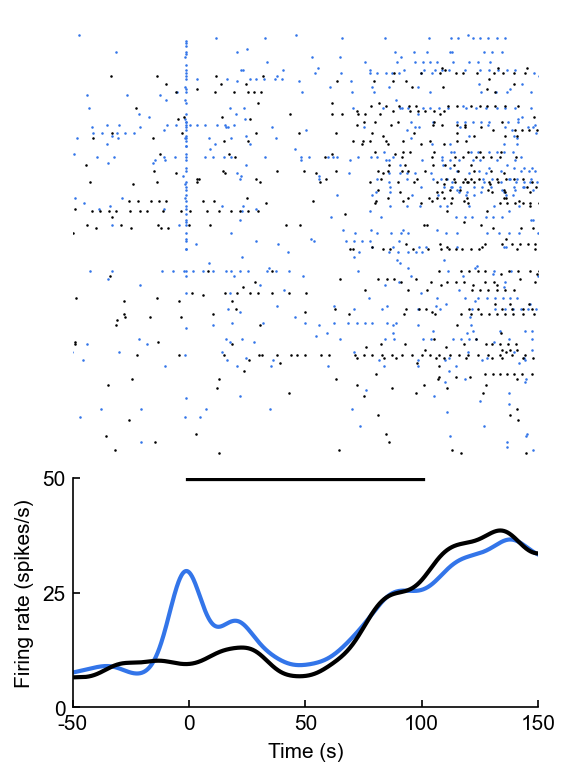

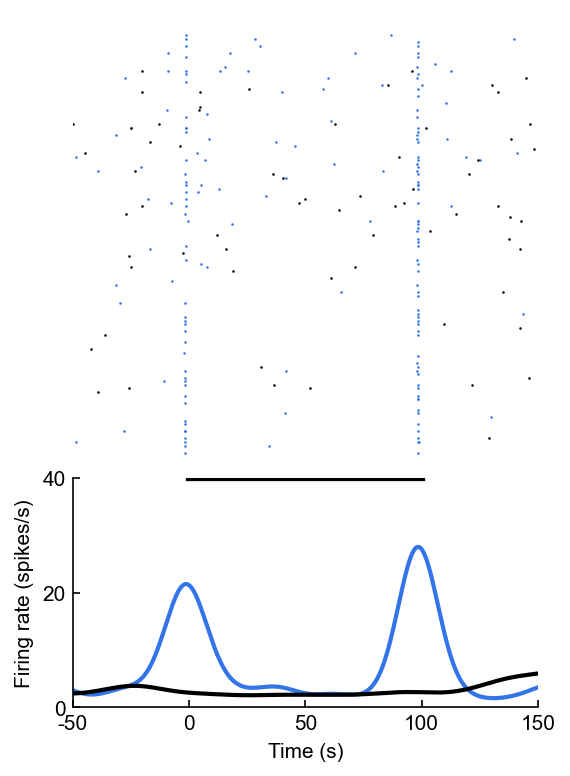

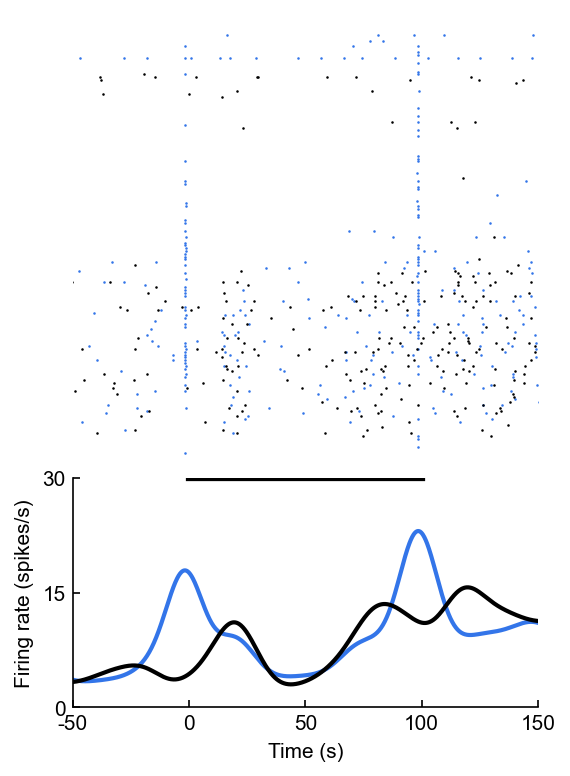

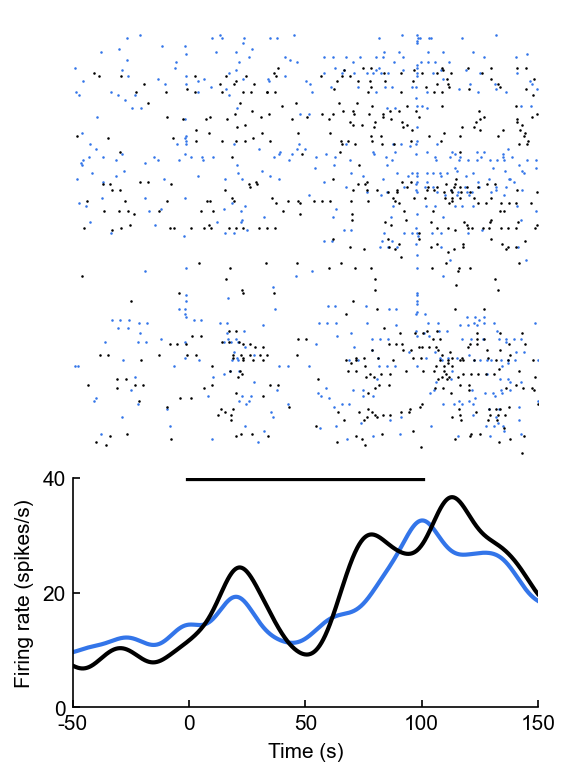

In [157]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[0])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)
    
    

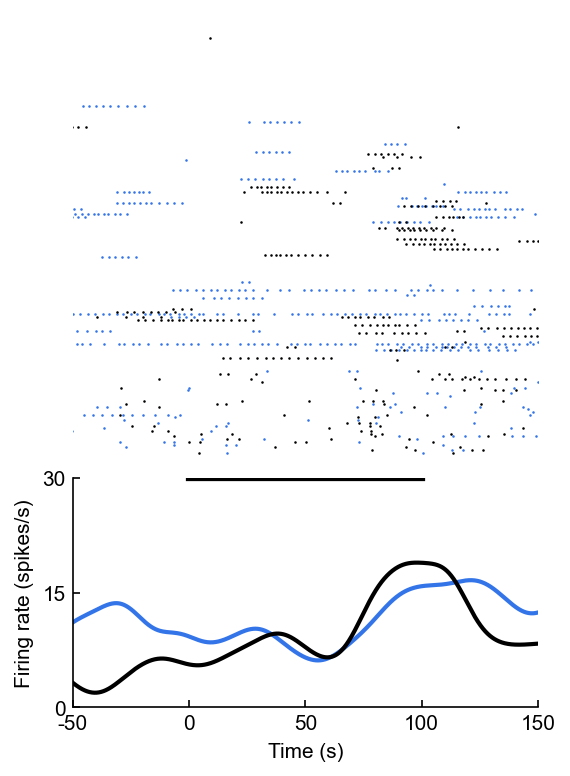

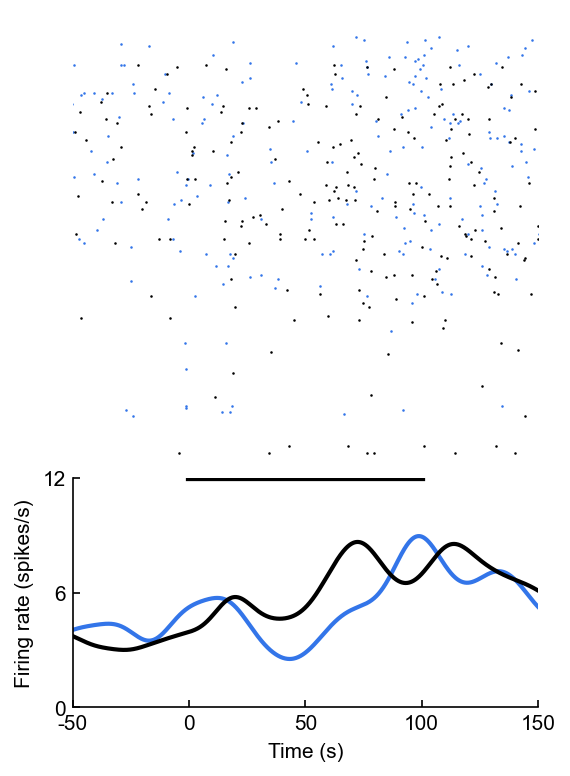

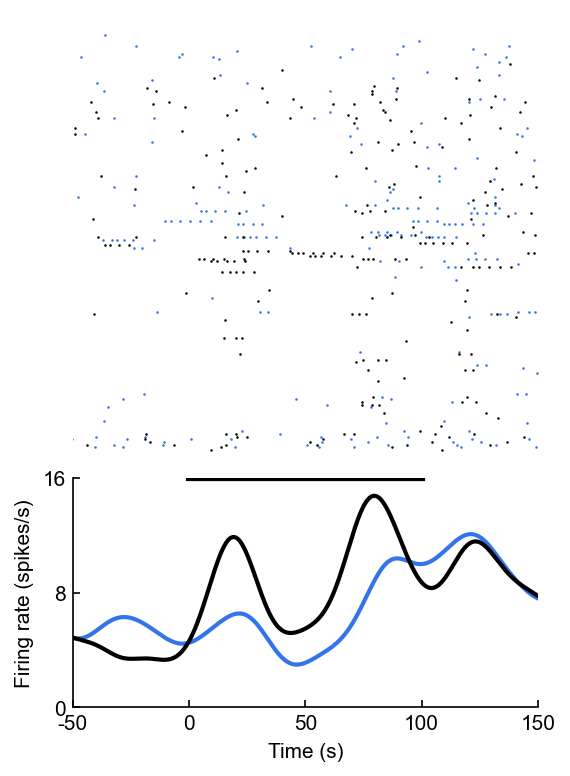

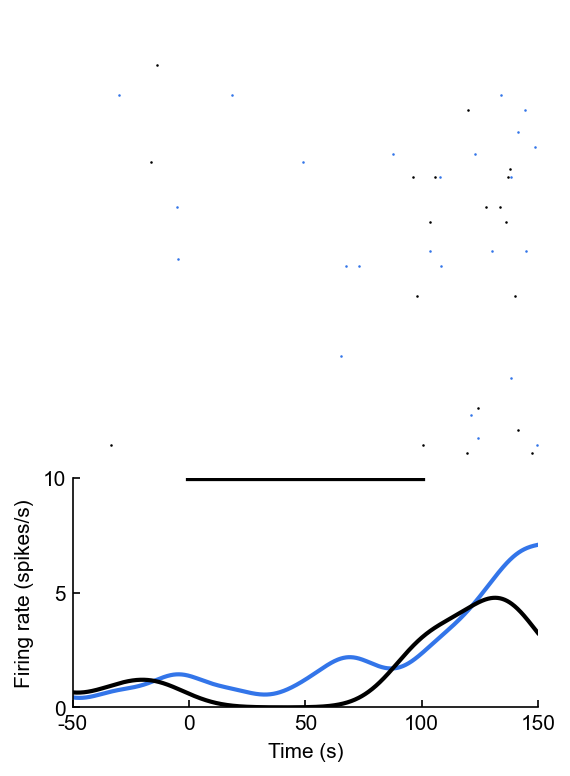

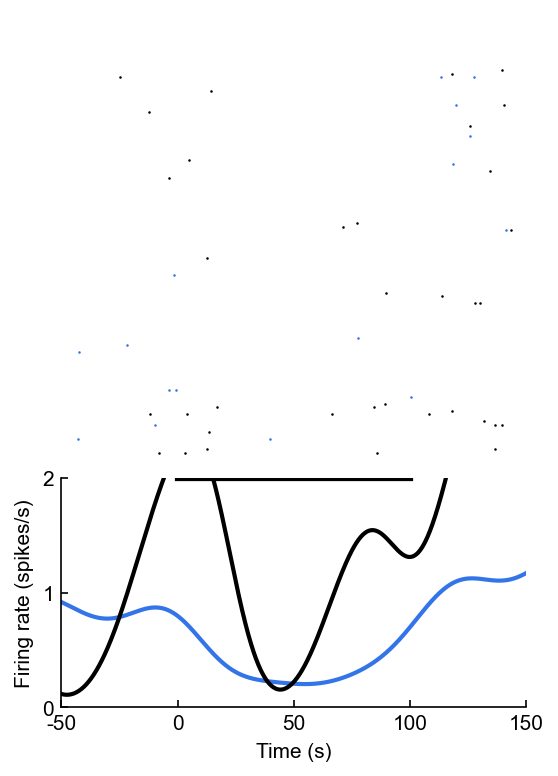

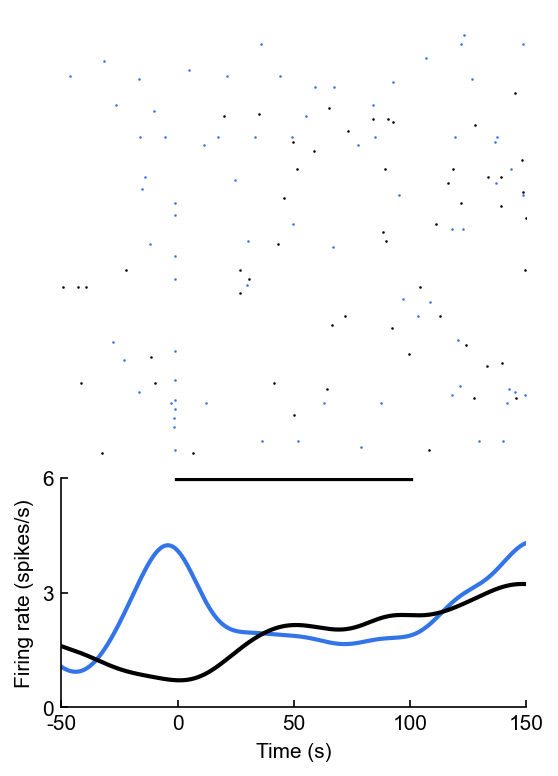

In [158]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[1])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)
    

In [162]:
############################

In [159]:
def visualizeCluster(sessionfile,clust):
    starttime = -0.05
    endtime = 0.15
    numbins = 100 + 1

    height=10
    width=1
    trans=0.125
    custommarker = mpl.path.Path([[-width,-height],[-width,height],[width,height],[width,-height]],closed=True)

    conditions = []

    condition = SimpleNamespace()
    laser_on = sessionfile.trials.laser_stimulation
    laser_on = np.array(np.where(laser_on)[0])
    laser_on = laser_on[np.isin(laser_on,sessionfile.trim[clust].trimmed_trials)]
    condition.trials = laser_on
    condition.label = 'ON'
    condition.color = LASER_COLOR
    conditions.append(condition)

    condition = SimpleNamespace()
    laser_off = np.logical_not(sessionfile.trials.laser_stimulation)
    laser_off = np.array(np.where(laser_off)[0])
    laser_off = laser_off[np.isin(laser_off,sessionfile.trim[clust].trimmed_trials)]

    condition.trials = laser_off
    condition.label = 'OFF'
    condition.color = 'k'
    conditions.append(condition)

    totaltrials = 0
    for cond in conditions:
        totaltrials += len(cond.trials)

    idx = np.equal(sessionfile.spikes.clusters,clust)
    totaltimes = sessionfile.spikes.times[idx]

    for cond in conditions:
        cond.timestoplot = []
        cond.trialstoplot = []
        cond.peristimulustimes = []

        for trialidx,trial in enumerate(cond.trials):
            trialstart = sessionfile.trials.starts[trial]

            #Caching search -- Condition
            idx = np.logical_and(np.greater(totaltimes,trialstart+starttime*sessionfile.meta.fs-0.25*30000) , np.less(totaltimes,trialstart+endtime*sessionfile.meta.fs+0.25*30000)     )
            times = totaltimes[idx]

            #PSTH times
            cond.peristimulustimes = np.concatenate((cond.peristimulustimes,(times-trialstart)/sessionfile.meta.fs*1000))
    #############################################---PLOTTING---#############################################

    plt.close('all')
    fig,ax = plt.subplots(figsize=(5,3))

    #Plot PSTHs
    bw=0.05
    xrange = np.linspace(starttime*1000,endtime*1000-starttime*1000,num=1000)
    ind = 0
    max_FR = -np.inf
    for cond in conditions:
        try:
            KDE = gaussian_kde((cond.peristimulustimes),bw_method=bw).evaluate(xrange)
            FR = KDE*len(cond.peristimulustimes) / len(cond.trials) * 1000
            targetmean = len(cond.peristimulustimes) / (endtime-starttime) / len(cond.trials)
            ax.plot(xrange,FR,c=cond.color,lw=2)

            max_FR = max(max_FR,np.max(FR))
        except Exception as e:
            print('PSTHs: '+str(e))
        ind = ind + 1

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing rate (spikes/s)')
    ax.tick_params(axis='x',direction='out')
    ax.set_xticks([-50,0,50,100,150])

    #ax.set_xlim(-50,200)


    max_FR_value = max_FR * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax.set_ylim([0,limit])
    ax.set_yticks([0,limit/2,limit])
    ax.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    
    return fig


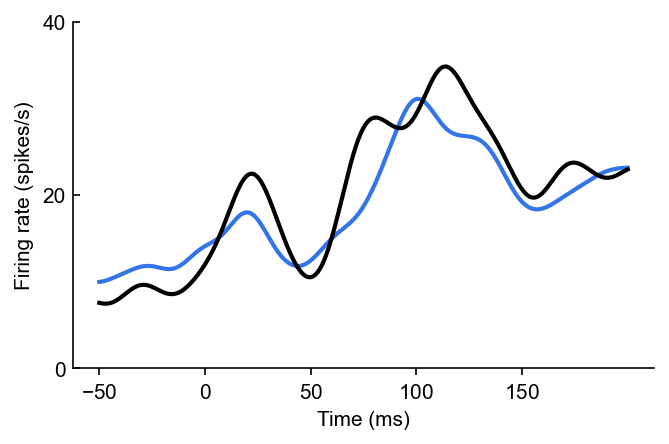

In [160]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[0])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)
    


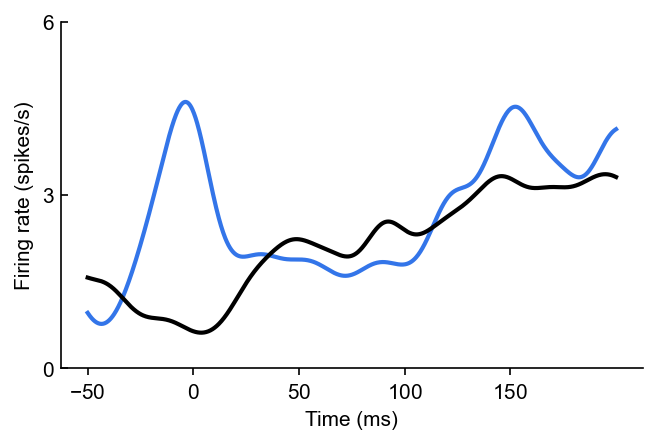

In [161]:
sessionfile = ilep.loadSessionCached(ops_directory,M2_sessions[1])
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)
    

In [127]:
############################

In [90]:
def visualizeCluster(sessionfile,clust):

    starttime = -250
    endtime = 1500
    bw_scott_factor = 3

    buffer = 500
    bufferedstart = starttime - buffer
    bufferedend = endtime + buffer
    startbuffer = (0-bufferedstart)/1000
    endbuffer = (bufferedend-2500)/1000 #NOTE THAT THIS IS CURRENTLY A HARDCODED VALUE!!!

    #########################################################################################

    region = sessionfile.meta.region

    #########################################################################################

    fig = plt.figure(figsize=(8,6))
    gs = fig.add_gridspec(2,2,height_ratios=[2,1],hspace=0.0125)#,wspace=0.5)#0.1)
    ax1 = plt.subplot(gs[0,0])#Raster
    ax2 = plt.subplot(gs[1,0],sharex=ax1)#PSTH
    
    ax3 = plt.subplot(gs[0,1])#Raster
    ax4 = plt.subplot(gs[1,1],sharex=ax1)#PSTH
    
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.get_xaxis().set_visible(False)
    ax3.get_yaxis().set_visible(False)

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)

    trialsToPlot_on = sessionfile.responsiveness[clust]['laser_on'].trials
    trialsToPlot_off = sessionfile.responsiveness[clust]['laser_off'].trials
    
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    
    trialSpikes_on = []
    trialSpikes_off = []
    
    for trial in trialsToPlot_on:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes_on.append(this_trial_spikes)
    trialSpikes_on = np.array(trialSpikes_on,dtype='object')

    for trial in trialsToPlot_off:
        this_trial_spikes = ilep.getTrialSpikes(sessionfile,trial,cachedtimes=clustSpikes,outunits='ms',startbuffer=startbuffer,endbuffer=endbuffer)
        trialSpikes_off.append(this_trial_spikes)
    trialSpikes_off = np.array(trialSpikes_off,dtype='object')

    
    #Plot Raster
    for idx,trial in enumerate(trialsToPlot_on):
        ax1.scatter(trialSpikes_on[idx],np.ones_like(trialSpikes_on[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
        
    for idx,trial in enumerate(trialsToPlot_off):
        ax3.scatter(trialSpikes_off[idx],np.ones_like(trialSpikes_off[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)



    #Plot PSTH
    #On
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_on)):
        PSTHspikes = np.concatenate(trialSpikes_on[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_on = np.mean(FR,axis=0)
    sem_FR_on = np.std(FR,axis=0)

    ax2.plot(xrange,avg_FR_on,lw=1,color=FRmod_color)
    ax2.fill_between(xrange,avg_FR_on-sem_FR_on,avg_FR_on+sem_FR_on,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)

    max_FR_value_on = np.max(avg_FR_on+sem_FR_on) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_on)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax2.set_ylim([0,limit])
    ax2.set_yticks([0,limit/2,limit])
    ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_ylabel('Firing rate (spikes/s)')

    ax2.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)

    ax2.set_xlim([starttime,endtime])
    ax2.set_xticks([0,500,1000,1500])
    ax2.set_xticklabels(['0','0.5','1','1.5'])
    ax2.set_xlabel('Time (s)')

    #Off
    PSTHstart = starttime - 0.1
    PSTHend = endtime + 0.1
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan)
    kf = KFold(n_splits=10)
    for idx,(train_index,_) in enumerate(kf.split(trialSpikes_off)):
        PSTHspikes = np.concatenate(trialSpikes_off[train_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR_off = np.mean(FR,axis=0)
    sem_FR_off = np.std(FR,axis=0)

    ax4.plot(xrange,avg_FR_off,lw=1,color=FRmod_color)
    ax4.fill_between(xrange,avg_FR_off-sem_FR_off,avg_FR_off+sem_FR_off,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)

    max_FR_value_off = np.max(avg_FR_off+sem_FR_off) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value_off)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax4.set_ylim([0,limit])
    ax4.set_yticks([0,limit/2,limit])
    ax4.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax4.set_ylabel('Firing rate (spikes/s)')

    ax4.plot([0,100],[limit,limit],color='k',lw=3,linestyle='-',zorder=10)

    ax4.set_xlim([starttime,endtime])
    ax4.set_xticks([0,500,1000,1500])
    ax4.set_xticklabels(['0','0.5','1','1.5'])
    ax4.set_xlabel('Time (s)')
    
    
    return fig,[ax1,ax2]





In [91]:
sessionfile.clusters.good

array([ 90, 104, 107, 124, 160, 167], dtype=int64)

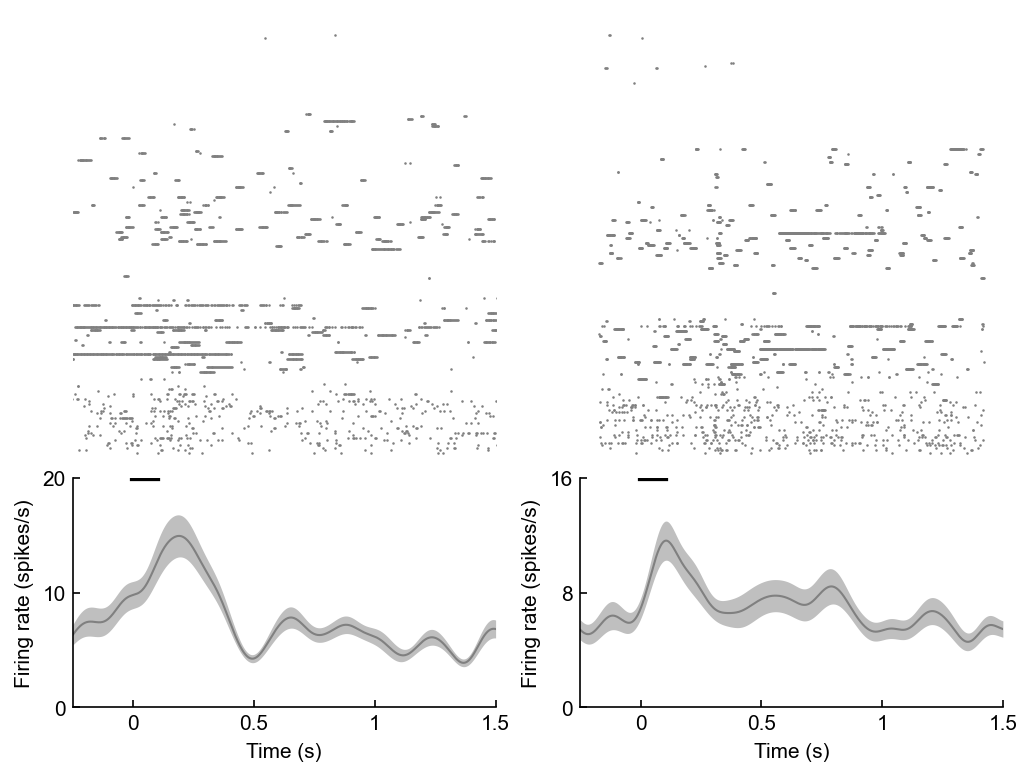

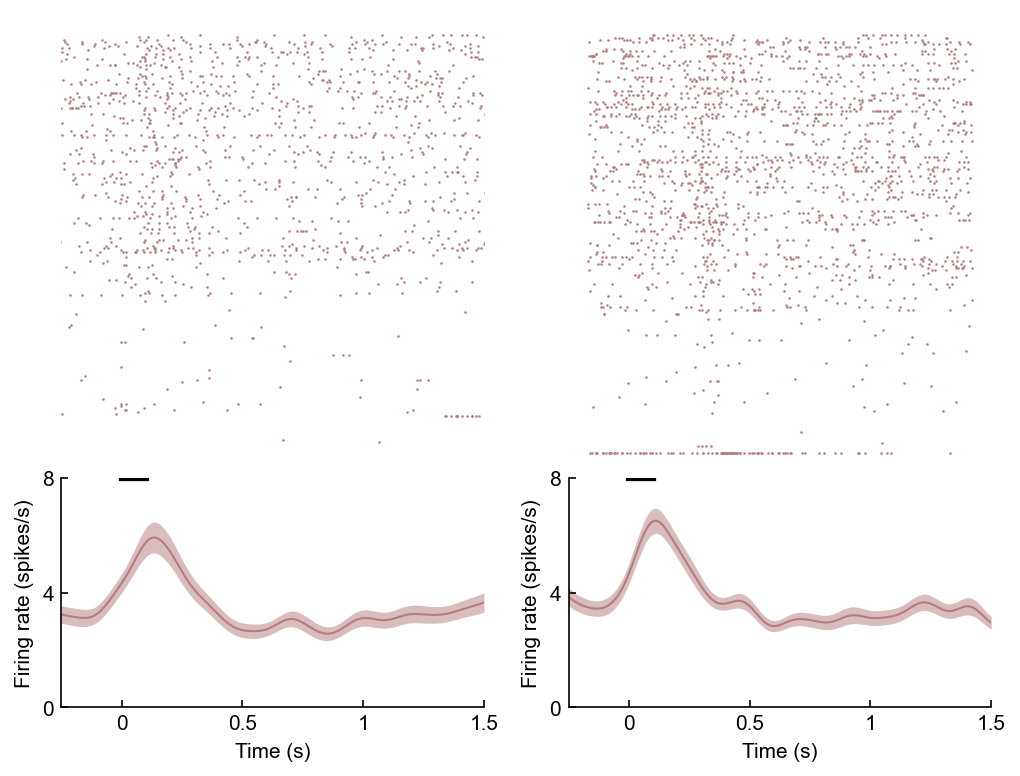

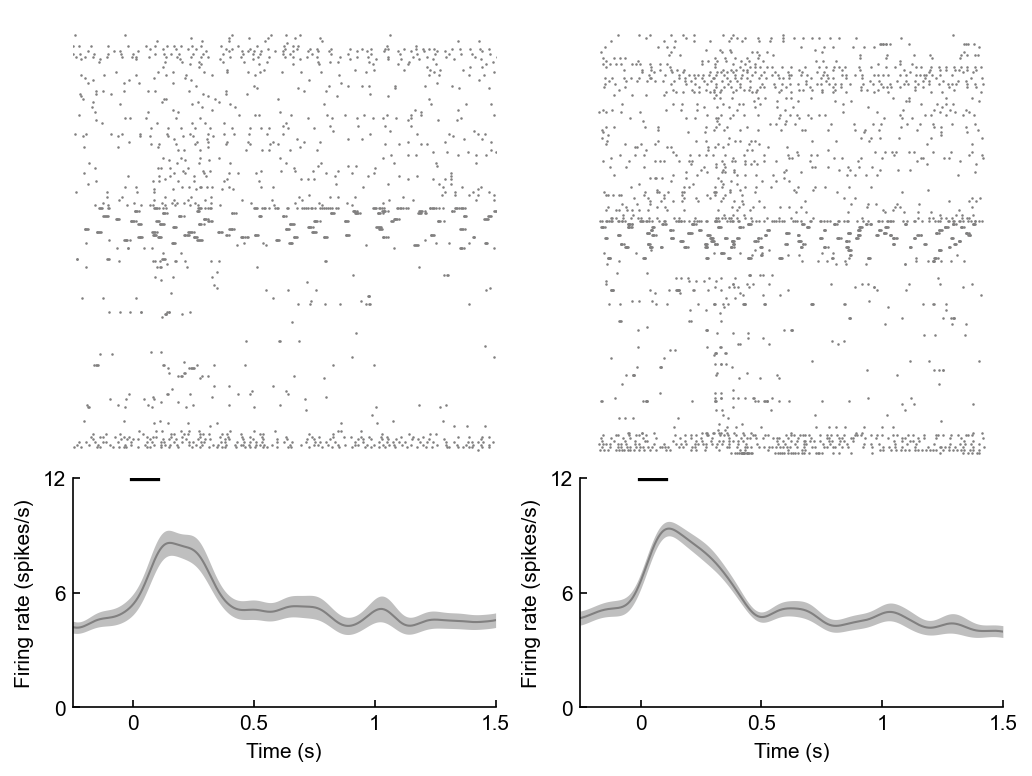

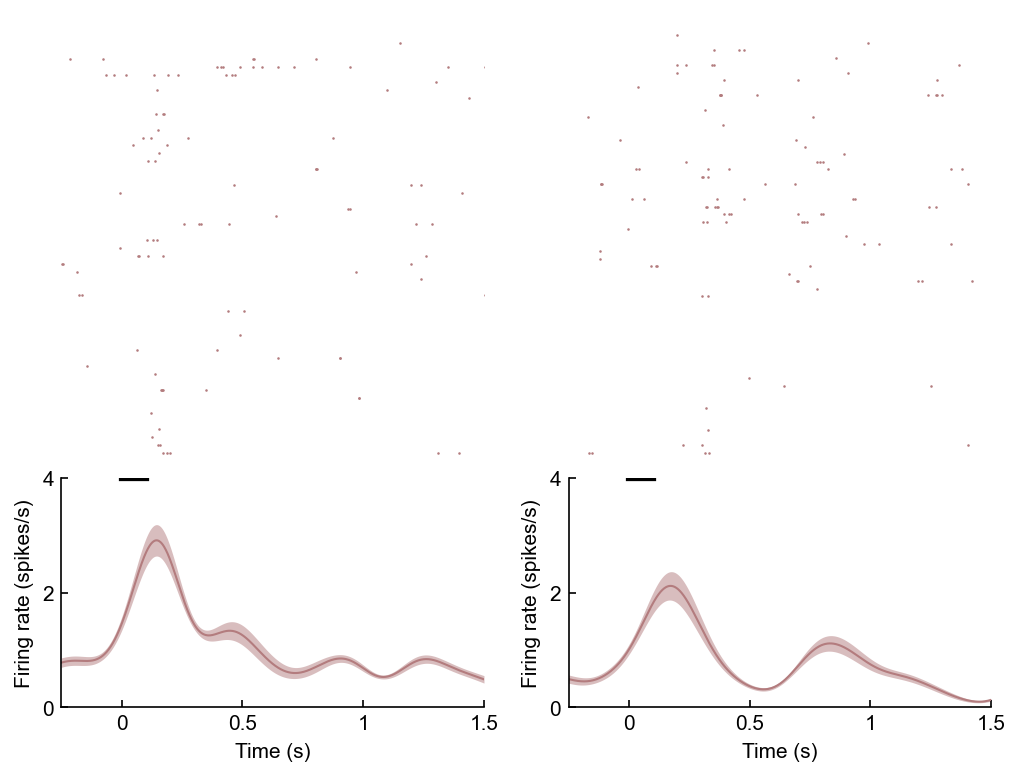

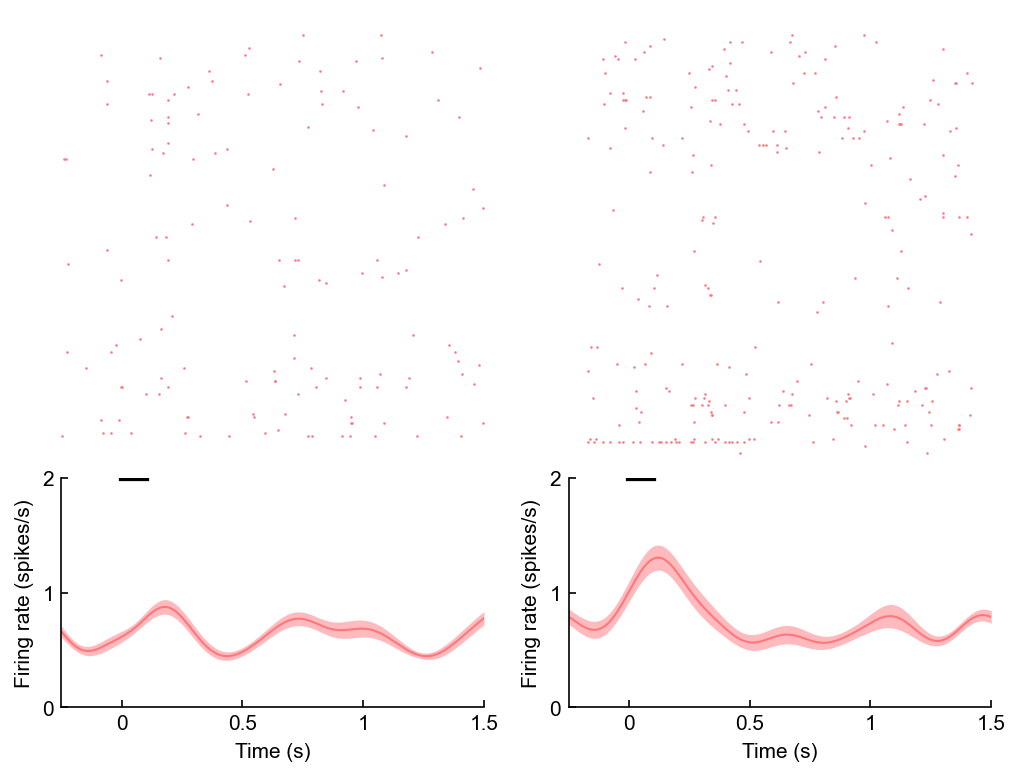

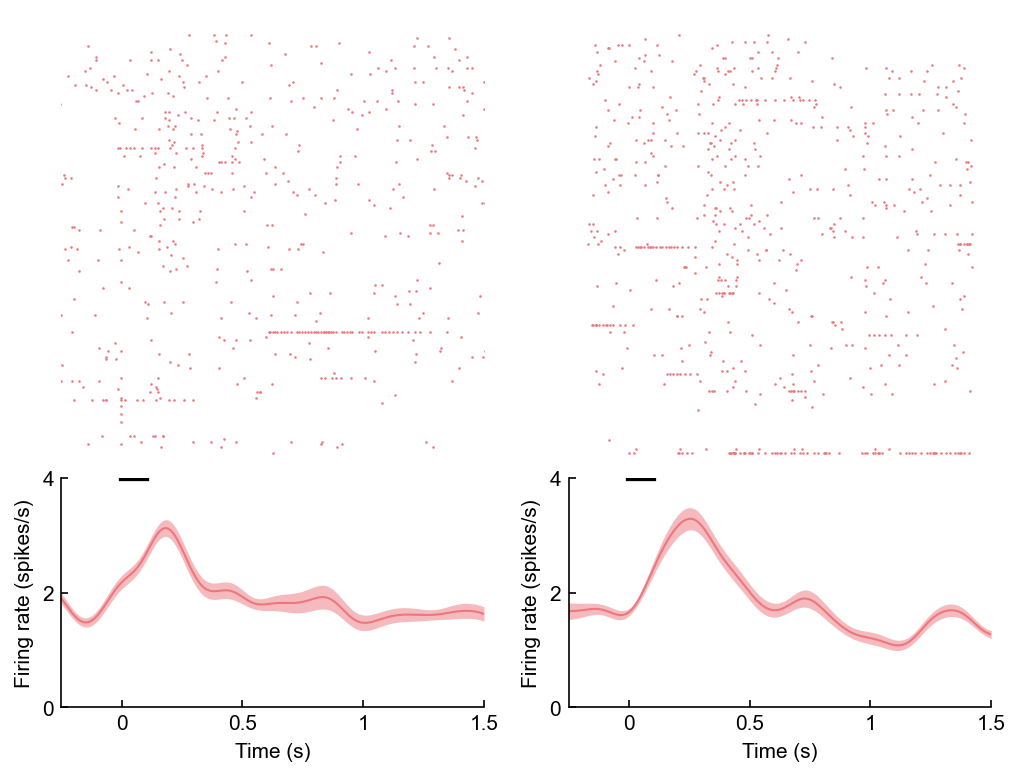

In [92]:
for clust in sessionfile.clusters.good:
    visualizeCluster(sessionfile,clust)